In [1]:
import kagglehub
osmankagankurnaz_acne_dataset_in_yolov8_format_path = kagglehub.dataset_download('osmankagankurnaz/acne-dataset-in-yolov8-format')
keras_yolov8_keras_yolo_v8_xs_backbone_2_path = kagglehub.model_download('keras/yolov8/Keras/yolo_v8_xs_backbone/2')

print('Data source import complete.')


Data source import complete.


In [2]:
!pip install keras_cv

In [3]:
# Importing dependencies

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import *
import keras_cv


BATCH_SIZE = 16
AUTO = tf.data.AUTOTUNE

# <span style="color:#e74c3c;"> </span> Preprocessing

In [4]:
# a function for converting txt file to list
def parse_txt_annot(img_path, txt_path):
    img = cv2.imread(img_path)
    w = int(img.shape[0])
    h = int(img.shape[1])

    file_label = open(txt_path, "r")
    lines = file_label.read().split('\n')

    boxes = []
    classes = []

    if lines[0] == '':
        return img_path, classes, boxes
    else:
        for i in range(0, int(len(lines))):
            objbud=lines[i].split(' ')
            class_ = int(objbud[0])

            x1 = float(objbud[1])
            y1 = float(objbud[2])
            w1 = float(objbud[3])
            h1 = float(objbud[4])

            xmin = int((x1*w) - (w1*w)/2.0)
            ymin = int((y1*h) - (h1*h)/2.0)
            xmax = int((x1*w) + (w1*w)/2.0)
            ymax = int((y1*h) + (h1*h)/2.0)

            boxes.append([xmin ,ymin ,xmax ,ymax])
            classes.append(class_)

    return img_path, classes, boxes


# a function for creating file paths list
def create_paths_list(path):
    full_path = []
    images = sorted(os.listdir(path))

    for i in images:
        full_path.append(os.path.join(path, i))

    return full_path


class_ids = ['Acne']
class_mapping = {0: 'Acne'}

In [5]:
# a function for creating a dict format of files
def creating_files(img_files_paths, annot_files_paths):

    img_files = create_paths_list(img_files_paths)
    annot_files = create_paths_list(annot_files_paths)

    image_paths = []
    bbox = []
    classes = []

    for i in range(0,len(img_files)):
        image_path_, classes_, bbox_ = parse_txt_annot(img_files[i], annot_files[i])
        image_paths.append(image_path_)
        bbox.append(bbox_)
        classes.append(classes_)

    image_paths = tf.ragged.constant(image_paths)
    bbox = tf.ragged.constant(bbox)
    classes = tf.ragged.constant(classes)

    return image_paths, classes, bbox

In [6]:
train_img_dir = osmankagankurnaz_acne_dataset_in_yolov8_format_path + '/data-2/train/images'
train_label_dir = osmankagankurnaz_acne_dataset_in_yolov8_format_path + '/data-2/train/labels'

valid_img_dir = osmankagankurnaz_acne_dataset_in_yolov8_format_path + '/data-2/valid/images'
valid_label_dir = osmankagankurnaz_acne_dataset_in_yolov8_format_path + '/data-2/valid/labels'

test_img_dir = osmankagankurnaz_acne_dataset_in_yolov8_format_path + '/data-2/test/images'
test_label_dir = osmankagankurnaz_acne_dataset_in_yolov8_format_path + '/data-2/test/labels'

# Applying functions
train_img_paths, train_classes, train_bboxes = creating_files(train_img_dir, train_label_dir)
valid_img_paths, valid_classes, valid_bboxes = creating_files(valid_img_dir, valid_label_dir)
test_img_paths, test_classes, test_bboxes = creating_files(test_img_dir, test_label_dir)

#### Preprocessing dataset

In [7]:
# reading and resizing images
def img_preprocessing(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.cast(img, tf.float32)

    return img


resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.8, 1.25),
    bounding_box_format="xyxy")

# loading dataset
def load_ds(img_paths, classes, bbox):
    img = img_preprocessing(img_paths)

    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox }

    return {"images": img, "bounding_boxes": bounding_boxes}

def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

In [8]:
# Creating dataset loaders and tf.datasets
train_loader = tf.data.Dataset.from_tensor_slices((train_img_paths, train_classes, train_bboxes))
train_dataset = (train_loader
                 .map(load_ds, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE*10)
                 .ragged_batch(BATCH_SIZE, drop_remainder = True)
                 .map(resizing, num_parallel_calls = AUTO)
                 .map(dict_to_tuple, num_parallel_calls = AUTO)
                 .prefetch(AUTO))


valid_loader = tf.data.Dataset.from_tensor_slices((valid_img_paths, valid_classes, valid_bboxes))
valid_dataset = (valid_loader
                 .map(load_ds, num_parallel_calls = AUTO)
                 .ragged_batch(BATCH_SIZE, drop_remainder = True)
                 .map(resizing, num_parallel_calls = AUTO)
                 .map(dict_to_tuple, num_parallel_calls = AUTO)
                 .prefetch(AUTO))


test_loader = tf.data.Dataset.from_tensor_slices((test_img_paths, test_classes, test_bboxes))
test_dataset = (test_loader
                .map(load_ds, num_parallel_calls = AUTO)
                .ragged_batch(BATCH_SIZE, drop_remainder = True)
                .map(resizing, num_parallel_calls = AUTO)
                .map(dict_to_tuple, num_parallel_calls = AUTO)
                .prefetch(AUTO))

In [9]:
# a function to visualize samples from a dataset

def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs[0], inputs[1]

    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale = 6,
        font_scale = 0.8,
        line_thickness=2,
        dpi = 100,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
        true_color = (192, 57, 43))

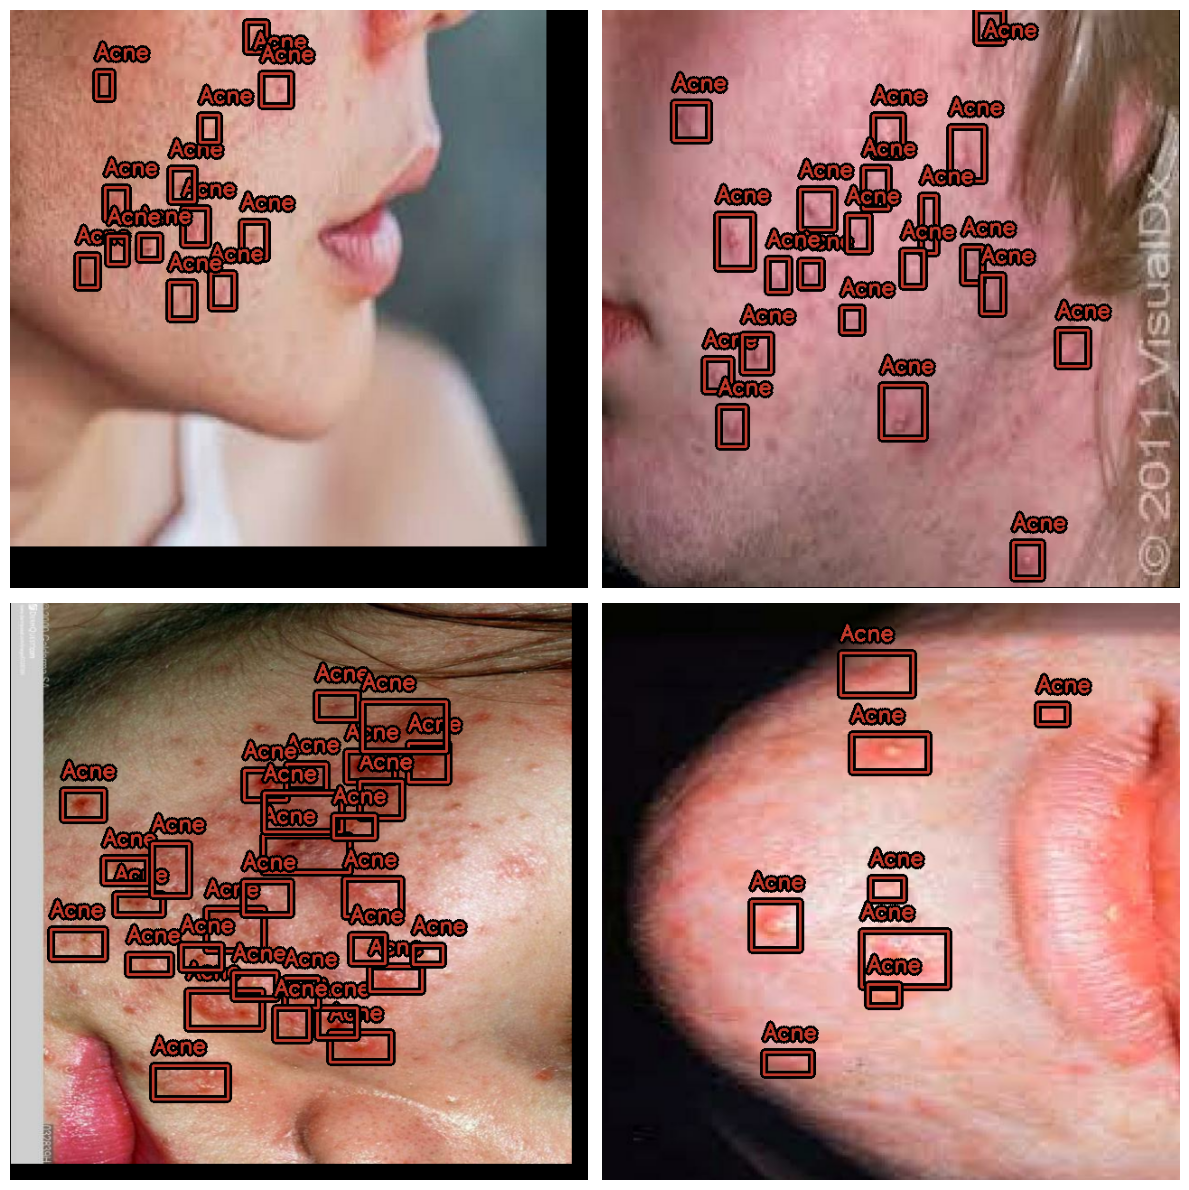

In [10]:
# examples images and annotations from training daatset
visualize_dataset(train_dataset, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2)

#### YOLO V8 Model

In [11]:
# creating mirrored strategy

stg = tf.distribute.MirroredStrategy()

In [12]:
# creating yolo backbone

with stg.scope():
    backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_xs_backbone", include_rescaling = True)

    YOLOV8_model = keras_cv.models.YOLOV8Detector(num_classes=len(class_mapping),
                                                  bounding_box_format = "xyxy", backbone = backbone, fpn_depth = 5)

    optimizer = AdamW(learning_rate=0.0007, weight_decay=0.0009, global_clipnorm = 10.0)
    my_callbacks = [ModelCheckpoint('/kaggle/working/yolo_acne_detection.weights.h5', monitor = 'val_loss',save_best_only = True, save_weights_only = True),
                ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=8, verbose=0, min_delta=0.001),
                EarlyStopping(monitor='val_loss', patience=20)]


    YOLOV8_model.compile(optimizer = optimizer, classification_loss = 'binary_crossentropy', box_loss = 'ciou')

# <span style="color:#e74c3c;"> Training </span>

In [13]:
hist = YOLOV8_model.fit(train_dataset, validation_data = valid_dataset,  epochs = 10, callbacks = my_callbacks)

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 89s 798ms/step - box_loss: 5.3904 - class_loss: 178.2116 - loss: 183.6019 - val_box_loss: 3.6165 - val_class_loss: 56.7108 - val_loss: 60.3273 - learning_rate: 7.0000e-04
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 38s 716ms/step - box_loss: 4.3700 - class_loss: 88.0744 - loss: 92.4444 - val_box_loss: 4.4456 - val_class_loss: 75.8329 - val_loss: 80.2786 - learning_rate: 7.0000e-04
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 760ms/step - box_loss: 3.9626 - class_loss: 33.4981 - loss: 37.4607 - val_box_loss: 3.7648 - val_class_loss: 28.3221 - val_loss: 32.0870 - learning_rate: 7.0000e-04
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 743ms/step - box_loss: 3.7688 - class_loss: 16.2440 - loss: 20.0128 - val_box_loss: 3.7766 - val_class_loss: 10.1522 - val_loss: 13.9288 - learning_rate: 7.0000e-04
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 751ms/step - box_loss: 3.7139 - class_loss: 8.2876 - loss: 12.0015 - val_box_loss: 3.4603 - val_class_loss: 6.1123 - val_loss: 9

In [14]:
model_save_path = '/content/acne_detection_model.keras'

# Save the model
YOLOV8_model.save(model_save_path)

print(f'Model saved at: {model_save_path}')

Model saved at: /content/acne_detection_model.keras


#### Test Predictions

In [15]:
YOLOV8_model.evaluate(test_dataset)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - box_loss: 2.4617 - class_loss: 2.1626 - loss: 4.6243


[4.681796073913574, 2.5031747817993164, 2.178621530532837]

In [19]:
import tensorflow as tf
from keras_cv import visualization

def visualize_predict_detections(model, dataset, bounding_box_format, class_mapping):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images, verbose=0)

    if isinstance(y_pred, tf.RaggedTensor):
        y_pred = y_pred.to_tensor()  

    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        true_color=(192, 57, 43),
        pred_color=(255, 235, 59),
        scale=8,
        font_scale=0.8,
        line_thickness=2,
        dpi=100,
        rows=2,
        cols=2,
        show=True,
        class_mapping=class_mapping,
    )


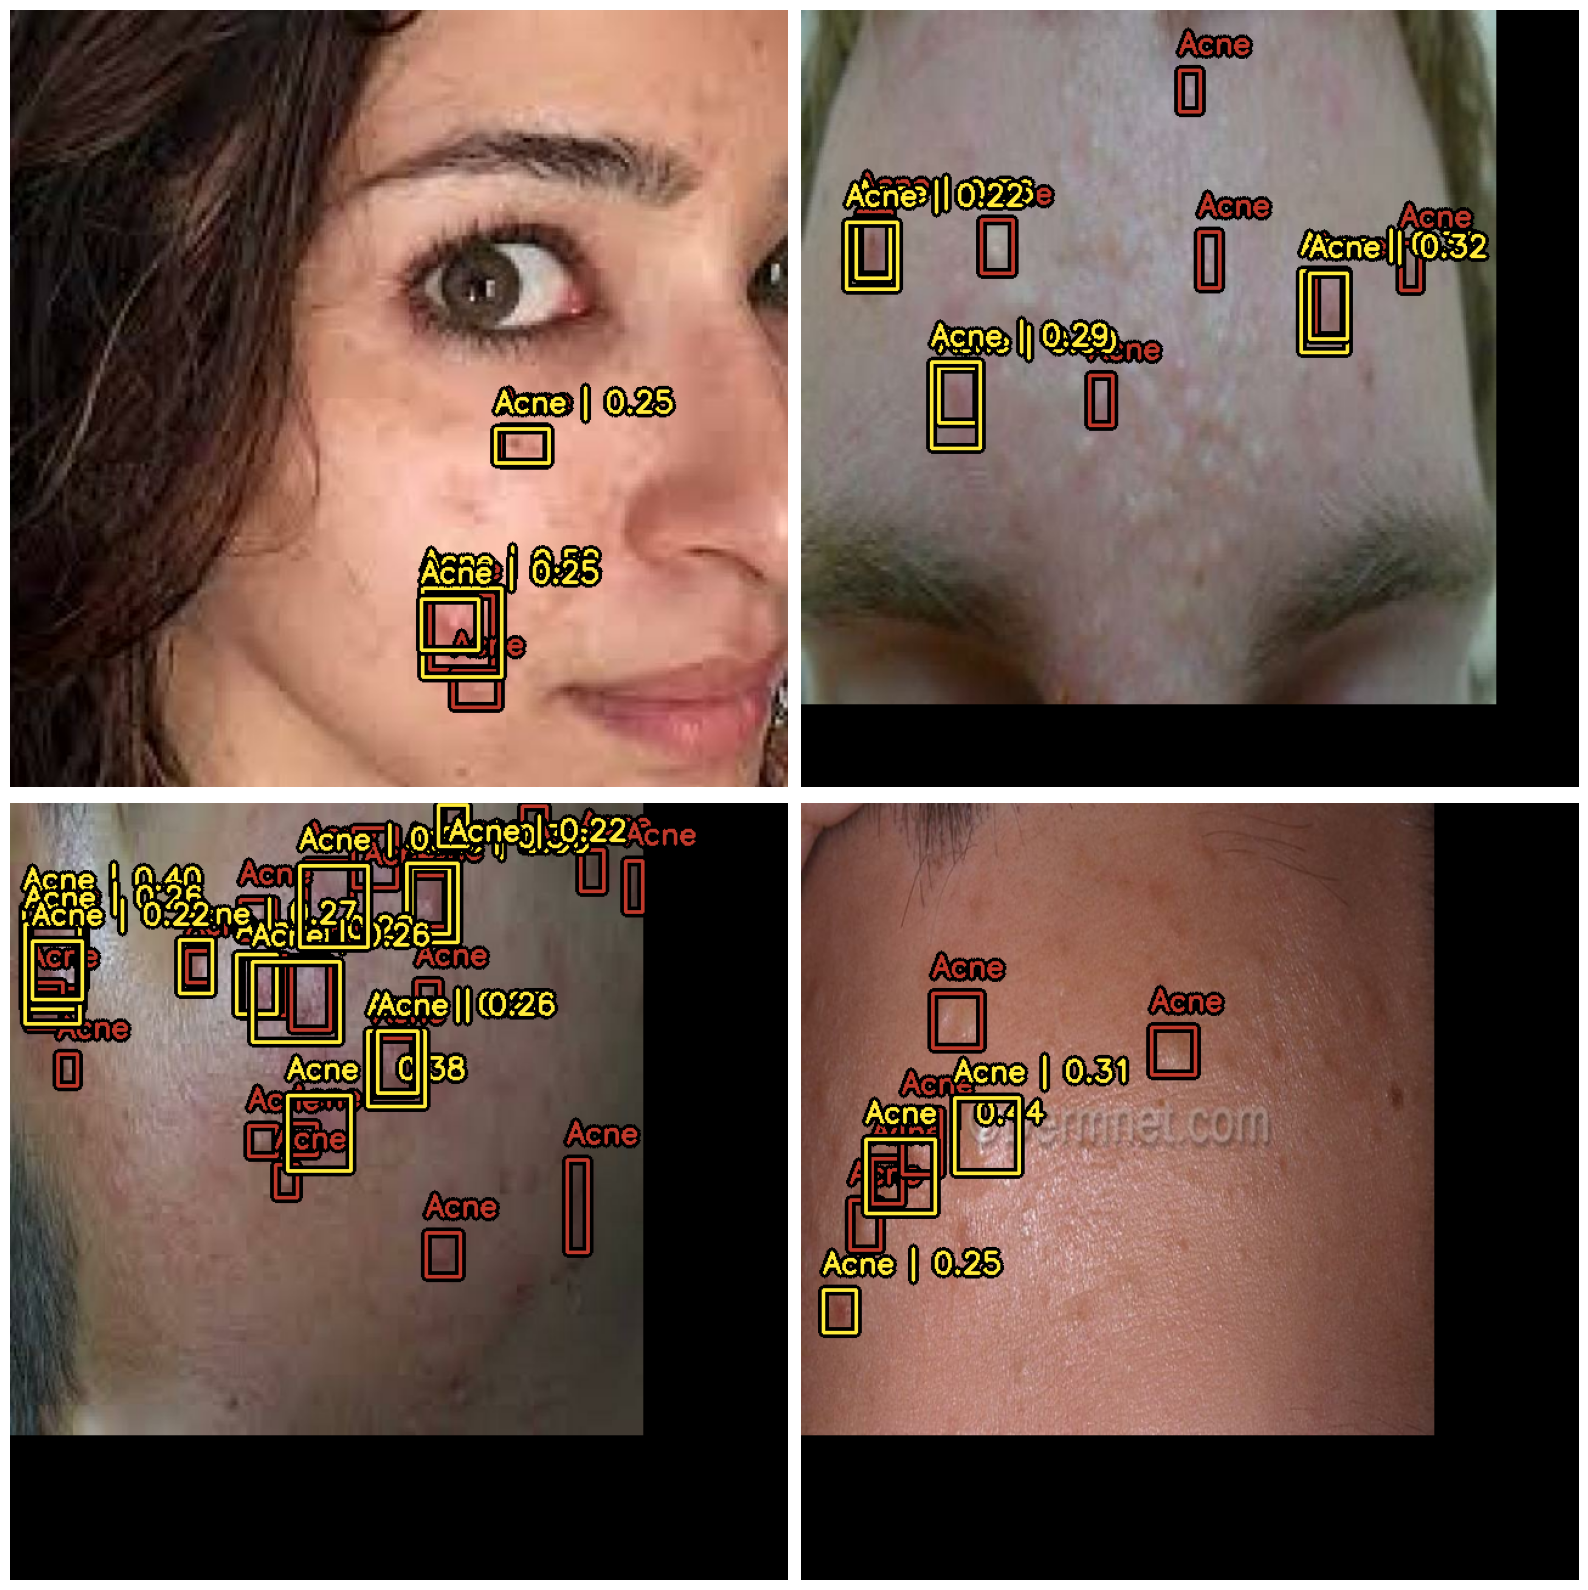

In [21]:
# red -> ground true
# yellow -> prediction

class_mapping = {
    0: 'Acne',  
    1: 'Other' 
}

# Load weights and visualize predictions
YOLOV8_model.load_weights('/kaggle/working/yolo_acne_detection.weights.h5')
visualize_predict_detections(YOLOV8_model, dataset=test_dataset, bounding_box_format="xyxy", class_mapping=class_mapping)

### Acne density

Acne density = number of acne / surface area

In [67]:
!pip install ultralytics
!pip install tensorflow

import os
from ultralytics import YOLO
import cv2
import pandas as pd
import tensorflow as tf  


import kagglehub

acne_dataset_path = kagglehub.dataset_download('osmankagankurnaz/acne-dataset-in-yolov8-format')

# Download the pre-trained YOLOv8 model with XS backbone - change to a PyTorch model
pretrained_model_path = 'yolov8s.pt'  # Load a PyTorch model from ultralytics


print('Data and model download complete.')


dataset_path = os.path.join(acne_dataset_path, 'data-2/') 
train_path = os.path.join(dataset_path, 'train/images')
val_path = os.path.join(dataset_path, 'valid/images')  
data_yaml_path = os.path.join(dataset_path, 'data.yaml')

model_path = pretrained_model_path

model = YOLO(model_path)  

model.train(data=data_yaml_path, epochs=50, imgsz=640, batch=16)

# Save the trained model
trained_model_path = "best.pt"
model.export(format="torchscript", save_dir=trained_model_path)

print(f'Model training complete. Best model saved at: {trained_model_path}')

Data and model download complete.


100%|██████████| 21.5M/21.5M [00:00<00:00, 209MB/s]


Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/root/.cache/kagglehub/datasets/osmankagankurnaz/acne-dataset-in-yolov8-format/versions/1/data-2/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False

100%|██████████| 755k/755k [00:00<00:00, 21.6MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 90.1MB/s]


AMP: checks passed ✅


train: Scanning /root/.cache/kagglehub/datasets/osmankagankurnaz/acne-dataset-in-yolov8-format/versions/1/data-2/train/labels... 823 images, 12 backgrounds, 0 corrupt: 100%|██████████| 823/823 [00:00<00:00, 1474.74it/s]

train: New cache created: /root/.cache/kagglehub/datasets/osmankagankurnaz/acne-dataset-in-yolov8-format/versions/1/data-2/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /root/.cache/kagglehub/datasets/osmankagankurnaz/acne-dataset-in-yolov8-format/versions/1/data-2/valid/labels... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<00:00, 483.25it/s]

val: New cache created: /root/.cache/kagglehub/datasets/osmankagankurnaz/acne-dataset-in-yolov8-format/versions/1/data-2/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.29G      2.273      2.378      1.524        115        640: 100%|██████████| 52/52 [00:20<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

                   all         56        643      0.473      0.397      0.347       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.48G      2.052      1.686       1.41         51        640: 100%|██████████| 52/52 [00:17<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         56        643      0.357      0.398       0.31      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.44G      2.031      1.669      1.409         68        640: 100%|██████████| 52/52 [00:17<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all         56        643      0.317      0.421      0.244     0.0977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.43G       1.97       1.63      1.358         95        640: 100%|██████████| 52/52 [00:17<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]

                   all         56        643      0.494      0.512      0.503      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.77G      1.957      1.634      1.359         45        640: 100%|██████████| 52/52 [00:17<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]

                   all         56        643      0.476      0.453       0.42      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.25G      1.933      1.544      1.334        257        640: 100%|██████████| 52/52 [00:17<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         56        643      0.509      0.512      0.506       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.38G       1.93      1.523      1.336        122        640: 100%|██████████| 52/52 [00:17<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         56        643      0.541      0.551      0.549      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.37G      1.908      1.516      1.317        156        640: 100%|██████████| 52/52 [00:17<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

                   all         56        643      0.537      0.479      0.509      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       4.4G      1.861      1.496      1.298        144        640: 100%|██████████| 52/52 [00:17<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         56        643      0.495      0.624      0.559       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       4.1G       1.88      1.456      1.309        205        640: 100%|██████████| 52/52 [00:16<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         56        643      0.497      0.526      0.523      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       4.2G      1.837      1.472      1.284        135        640: 100%|██████████| 52/52 [00:17<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all         56        643      0.538      0.547      0.533      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.82G      1.833      1.437      1.282        127        640: 100%|██████████| 52/52 [00:17<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         56        643      0.518      0.563      0.566      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       4.6G      1.848      1.423      1.295        118        640: 100%|██████████| 52/52 [00:17<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]

                   all         56        643      0.569      0.603      0.589      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.48G      1.842      1.421      1.284        123        640: 100%|██████████| 52/52 [00:17<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]

                   all         56        643      0.558      0.515       0.55      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.96G      1.821      1.408      1.304        127        640: 100%|██████████| 52/52 [00:16<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]

                   all         56        643      0.605      0.583      0.595      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.44G      1.837      1.456      1.294         74        640: 100%|██████████| 52/52 [00:17<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]

                   all         56        643      0.568      0.555      0.557       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.27G      1.809      1.369      1.271         98        640: 100%|██████████| 52/52 [00:17<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all         56        643      0.582       0.53      0.569      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.14G      1.797       1.37      1.268        138        640: 100%|██████████| 52/52 [00:17<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]

                   all         56        643      0.527      0.504      0.505       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       4.5G      1.795      1.368      1.271         85        640: 100%|██████████| 52/52 [00:17<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         56        643      0.566       0.55       0.55      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.24G      1.778      1.338      1.258        106        640: 100%|██████████| 52/52 [00:17<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]

                   all         56        643      0.563      0.576      0.583      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.19G      1.794      1.335      1.273         85        640: 100%|██████████| 52/52 [00:17<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]

                   all         56        643      0.557      0.572      0.581      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.32G      1.763      1.313      1.259         94        640: 100%|██████████| 52/52 [00:17<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         56        643      0.594      0.557      0.598      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.49G      1.763      1.289      1.258        103        640: 100%|██████████| 52/52 [00:16<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all         56        643       0.59      0.561      0.588      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.18G      1.756      1.293      1.255         77        640: 100%|██████████| 52/52 [00:16<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         56        643      0.604      0.577      0.577      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.72G      1.726      1.249      1.243        117        640: 100%|██████████| 52/52 [00:17<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]

                   all         56        643      0.582      0.615      0.591      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.31G      1.727       1.25       1.23        137        640: 100%|██████████| 52/52 [00:17<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         56        643      0.596       0.58      0.596      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.54G      1.713      1.254      1.236        112        640: 100%|██████████| 52/52 [00:16<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

                   all         56        643      0.569      0.588       0.59      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.65G      1.712      1.229       1.24        136        640: 100%|██████████| 52/52 [00:17<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         56        643      0.594      0.571      0.572      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.33G      1.708       1.22      1.221        118        640: 100%|██████████| 52/52 [00:16<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all         56        643      0.609      0.583      0.608      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.18G      1.705      1.219      1.224        214        640: 100%|██████████| 52/52 [00:17<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         56        643      0.566      0.621      0.605      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.33G       1.69      1.204      1.217         98        640: 100%|██████████| 52/52 [00:17<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.49it/s]

                   all         56        643      0.562       0.61      0.584      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.36G      1.688      1.183      1.224        105        640: 100%|██████████| 52/52 [00:17<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]

                   all         56        643      0.575      0.582      0.574      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.62G      1.686      1.176      1.225        103        640: 100%|██████████| 52/52 [00:17<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         56        643      0.604      0.579      0.595      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.31G      1.642      1.146      1.201        122        640: 100%|██████████| 52/52 [00:17<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         56        643      0.551      0.663      0.605       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.88G      1.648      1.135      1.195         86        640: 100%|██████████| 52/52 [00:17<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         56        643      0.614      0.589      0.602      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.21G      1.634      1.128      1.197        173        640: 100%|██████████| 52/52 [00:17<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.58it/s]

                   all         56        643      0.602      0.577      0.591      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.43G      1.642      1.119      1.191        287        640: 100%|██████████| 52/52 [00:17<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all         56        643      0.543      0.563      0.526      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.37G      1.642      1.113      1.213         84        640: 100%|██████████| 52/52 [00:17<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         56        643      0.593      0.607      0.612      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.98G      1.632      1.109      1.191        138        640: 100%|██████████| 52/52 [00:17<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]

                   all         56        643      0.586      0.583      0.592       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.26G      1.602      1.076      1.177        145        640: 100%|██████████| 52/52 [00:17<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]

                   all         56        643       0.52      0.619      0.574       0.27


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         4G      1.591      1.088      1.228         64        640: 100%|██████████| 52/52 [00:19<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         56        643       0.55      0.628       0.61      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.99G       1.57       1.06      1.212         85        640: 100%|██████████| 52/52 [00:16<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         56        643       0.62      0.556      0.598      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.92G       1.55      1.028      1.215         77        640: 100%|██████████| 52/52 [00:16<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         56        643      0.595      0.614      0.597      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.03G      1.528     0.9966      1.195         93        640: 100%|██████████| 52/52 [00:16<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         56        643      0.618      0.575      0.612      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.02G      1.521     0.9822      1.201         73        640: 100%|██████████| 52/52 [00:17<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

                   all         56        643      0.572       0.64      0.599      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.01G      1.528     0.9782      1.206         73        640: 100%|██████████| 52/52 [00:16<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]

                   all         56        643      0.588      0.608      0.575      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.89G      1.501     0.9726      1.192         99        640: 100%|██████████| 52/52 [00:16<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         56        643      0.582      0.639      0.603      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.89G      1.483     0.9532      1.189        140        640: 100%|██████████| 52/52 [00:16<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]

                   all         56        643      0.597      0.625        0.6      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.02G      1.473     0.9244      1.167        107        640: 100%|██████████| 52/52 [00:16<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

                   all         56        643      0.578      0.638      0.608      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.06G       1.46     0.9188      1.164         83        640: 100%|██████████| 52/52 [00:17<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

                   all         56        643      0.577      0.635      0.602      0.272



50 epochs completed in 0.271 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


                   all         56        643      0.569      0.617      0.605      0.282
Speed: 0.6ms preprocess, 4.7ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/detect/train
Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (21.5 MB)

TorchScript: starting export with torch 2.5.1+cu121...
TorchScript: export success ✅ 3.6s, saved as 'runs/detect/train/weights/best.torchscript' (42.9 MB)

Export complete (6.1s)
Results saved to /content/runs/detect/train/weights
Predict:         yolo predict task=detect model=runs/detect/train/weights/best.torchscript imgsz=640  
Validate:        yolo val task=detect model=runs/detect/train/weights/best.torchscript imgsz=640 data=/root/.cache/kagglehub/datasets/osmankagankurnaz/acne


0: 640x640 (no detections), 18.8ms
Speed: 2.5ms preprocess, 18.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


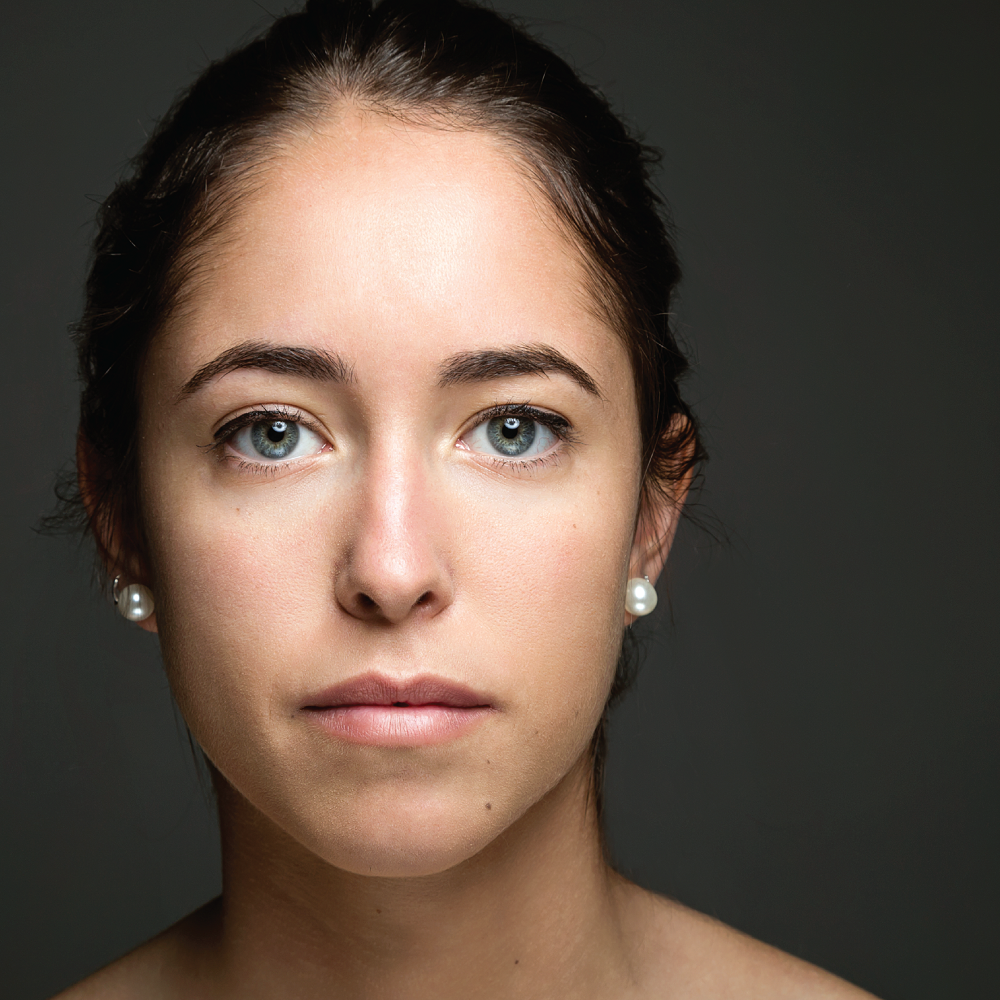

Acne Count: 0
Surface Area: 0
Acne Density: 0.0

0: 640x640 25 Acnes, 16.4ms
Speed: 2.8ms preprocess, 16.4ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 640)


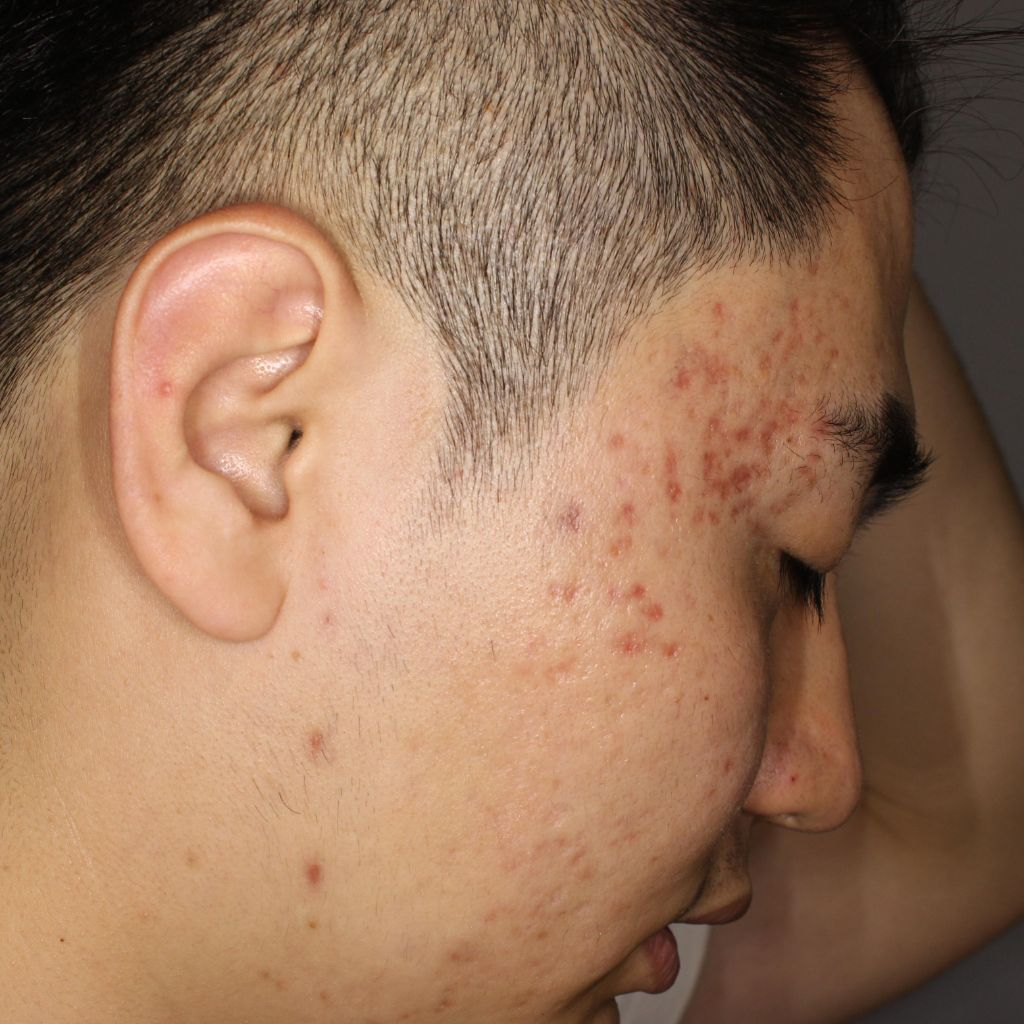

Acne Count: 25
Surface Area: 6047.870056152344
Acne Density: 2.384185791015625e-05


In [74]:
from google.colab.patches import cv2_imshow

def calculate_acne_density(image_path, model):
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (640, 640))  
    results = model(img_resized)

    detections = results[0].boxes.xyxy.cpu().numpy()  

    # Count the number of acne lesions (detections)
    acne_count = len(detections)

    surface_area = 0
    for detection in detections:
        width = detection[2] - detection[0]  # x2 - x1
        height = detection[3] - detection[1]  # y2 - y1
        surface_area += width * height

    # Acne density calculation (acne count per surface area of the image)
    image_area = img.shape[0] * img.shape[1]  # Image total surface area (height * width)
    acne_density = acne_count / image_area  # Density = count / total area

    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return acne_count, surface_area, acne_density

image_path = "img.png"  
img_path1 = "image.jpg"
acne_count, surface_area, acne_density = calculate_acne_density(image_path, model)

print(f"Acne Count: {acne_count}")
print(f"Surface Area: {surface_area}")
print(f"Acne Density: {acne_density}")

acne_count, surface_area, acne_density = calculate_acne_density(img_path1, model)

print(f"Acne Count: {acne_count}")
print(f"Surface Area: {surface_area}")
print(f"Acne Density: {acne_density}")